In [8]:
!mkdir -p data models
!curl -L -o data/waste-classification-data-trainvaltest-short.zip\
  https://www.kaggle.com/api/v1/datasets/download/stanislav9801/waste-classification-data-trainvaltest-short
!unzip data/waste-classification-data-trainvaltest-short.zip -d data/
!rm data/waste-classification-data-trainvaltest-short.zip

In [2]:
!pip install lightning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [50]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.v2 as tfs
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

from lightning import LightningDataModule, LightningModule, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch import seed_everything

In [56]:
@dataclass
class CFG:
    seed: int = 42
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    lr_fc: float = 1e-3
    batch_size: int = 128
    num_workers: int = 2
    data_dir: str = 'data/DATASET'
    models_dir: str = 'models'
    unfreeze_epoch: int = 10
    lr_backbone: int = 1e-4

cfg = CFG()
seed_everything(cfg.seed)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

In [5]:
def image_preview(img: np.ndarray):
    """Предпросмотр изображений
    """
    img_transpose = np.transpose(img, (1, 2, 0))
    # Нормализуем значения в диапазон от 0 до 255
    img_transpose_normalized = ((img_transpose - img_transpose.min()) / (img_transpose.max() - img_transpose.min()) * 255).astype(np.uint8)
    plt.imshow(img_transpose_normalized)

In [6]:
train_transforms = tfs.Compose([tfs.RandomRotation(30),
                                      tfs.RandomResizedCrop(224),
                                      tfs.RandomHorizontalFlip(),
                                      tfs.ToTensor(),
                                      tfs.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
test_transforms = tfs.Compose([tfs.Resize(255),
                                     tfs.CenterCrop(224),
                                     tfs.ToTensor(),
                                     tfs.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [7]:
train_data = datasets.ImageFolder(cfg.data_dir+'/TRAIN', transform=train_transforms)
val_data = datasets.ImageFolder(cfg.data_dir+'/VAL', transform=test_transforms)
test_data = datasets.ImageFolder(cfg.data_dir+'/TEST', transform=test_transforms)

In [8]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
dataiter = iter(train_loader)
im, lab = next(dataiter)
im = im.numpy()

In [11]:
im.shape

(128, 3, 224, 224)

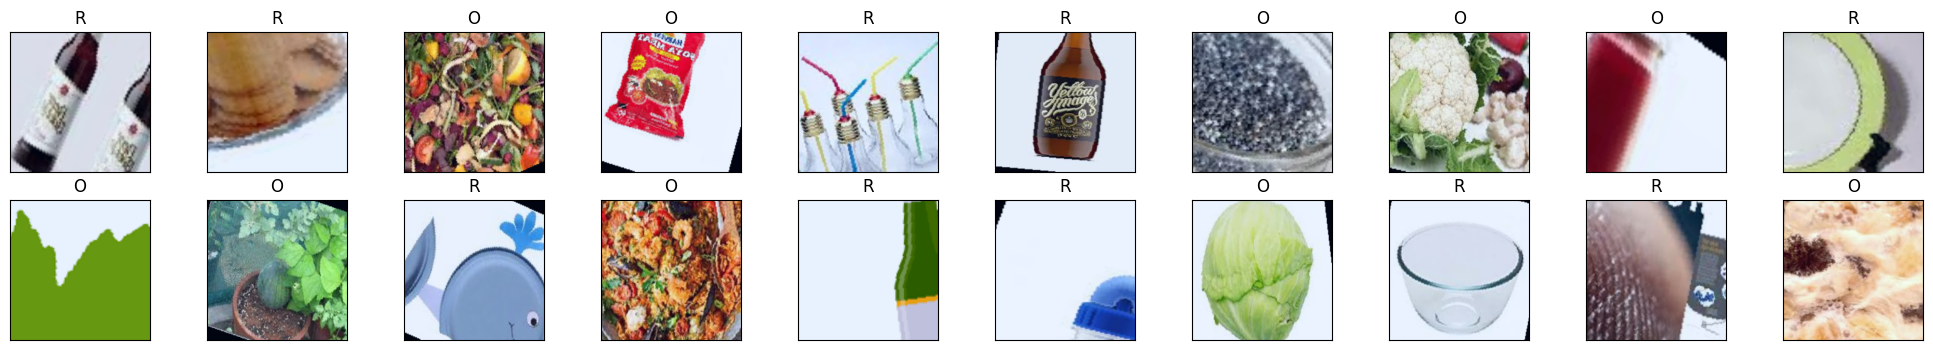

In [12]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    image_preview(im[idx])
    ax.set_title(train_data.classes[lab[idx]])

In [17]:
class WasteClassifierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')  #(B, 3, H, W) -> (B, 32, H, W)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same') #(B, 32, H, W) -> (B, 64, H, W)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding='same')

        self.dropout = nn.Dropout(.5)

        self.fc1 = nn.Linear(128*56*56, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        import pdb; pdb.set_trace()
        x = F.relu(self.conv1(x)) # (32, 224, 224)
        x = F.relu(self.conv2(x)) #(64, 224, 224)
        x = self.pool(x) #(64, 112, 112)

        x = F.relu(self.conv3(x)) #(128, 112, 112)
        x = F.relu(self.conv4(x)) #(128, 112, 112)
        x = self.pool(x) #(128, 56, 56)

        x = x.view(x.size(0), -1) #flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [66]:
class WasteLitModel(LightningModule):
    def __init__(self, unfreeze_epoch=3, lr_fc=1e-3, lr_backbone=1e-4):
        super().__init__()

        self.lr_fc = lr_fc
        self.lr_backbone = lr_backbone
        self.backbone_unfrozen = False  # чтобы не разморозить дважды
        self.unfreeze_epoch = unfreeze_epoch

        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        #self.model = torch.compile(model)
        for param in self.model.parameters():
          param.requires_grad = False

        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 2)
        for param in self.model.fc.parameters():
          param.requires_grad = True

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def basic_step(self, batch, batch_idx, stage):
        x, y = batch
        preds = self(x)
        loss = self.loss(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log(f"{stage}_loss", loss, prog_bar=True)
        self.log(f"{stage}_acc", acc, prog_bar=True)
        return loss

    def on_train_epoch_start(self):
        if (self.current_epoch == self.unfreeze_epoch) and not self.backbone_unfrozen:
          for param in self.model.parameters():
            param.requires_grad = True
          self.backbone_unfrozen = True

    def training_step(self, batch, batch_idx):
        return self.basic_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self.basic_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.basic_step(batch, batch_idx, 'test')

    def configure_optimizers(self):
        if not self.backbone_unfrozen:
          return optim.Adam(self.parameters(), lr=self.lr_fc)
        else:
          return optim.Adam([
              {"params": self.model.fc.parameters(), "lr": self.lr_fc},
              {"params": [p for n, p in self.model.named_parameters() if "fc" not in n], "lr": self.lr_backbone}
          ])


In [85]:
checkpoint_cb = ModelCheckpoint(
        monitor="val_acc",
        mode="max",
        save_top_k=2,
        filename="waste-resnet18-{epoch:02d}-{val_acc:.4f}",
        dirpath=cfg.models_dir
)
early_stop_cb = EarlyStopping(monitor='val_acc', mode='max', patience=3)

model = WasteLitModel(unfreeze_epoch=10, lr_fc=1e-3, lr_backbone=1e-4)
trainer = Trainer(
    max_epochs=10,
    precision=16,
    accelerator=cfg.device,
    callbacks=[
        checkpoint_cb,
        early_stop_cb,
        ]
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | ResNet           | 11.2 M | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [86]:
trainer.test(model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8999999761581421     │
│         test_loss         │    0.2935478687286377     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2935478687286377, 'test_acc': 0.8999999761581421}]

In [103]:
!ls models/ | sort -t '=' -k 3 -n | tail -2

waste-resnet18-epoch=05-val_acc=0.9340.ckpt
waste-resnet18-epoch=09-val_acc=0.9380.ckpt
